## 전이 학습
  - 뇌 사진과 관련없는 수백만 장의 이미지넷 학습 정보가 큰 역할을 하는 이유는, ‘형태’를 구분하는 기본적인 학습이 되어 있기 때문
  - 사전에 학습한 층을 앞에(하위 층), 추가로 학습할 층(상위 층)을 뒤측에 두는데, 이를 바꾸게 되면 안될까?
  - 특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성), 수준은 모델에 있는 층의 깊이에 달려있습니다. 모델의 하위층은 지역적이고 매우 일반적인 특성 맵(에지, 색깔, 질감 등)을 추출하며, 반면에 상위 층은 좀 더 추상적인 개념(강아지 눈이나 고양이 귀 처럼)을 추출합니다. 
  - 분류기 - 활성화 함수

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       'example/080228-master/deeplearning/run_project/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       'example/080228-master/deeplearning/run_project/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [4]:

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()# 분류기는 우리 것을 쓸 것이기 때문에, include_top=False

58892288/58889256 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________________________

In [5]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)# 4 * 4로 들어오는 모델을 받아서, 1차원으로 변경
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation = 'softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
finetune_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [7]:
history = finetune_model.fit_generator(
       train_generator,
       steps_per_epoch=len(train_generator),
       epochs=20, # 학습된 가중치를 가져오기 떄문에, 20번도 상관 없음
       validation_data=test_generator,
       validation_steps=len(test_generator))


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 24 steps
Epoch 1/20
32/32 [==============================] - 6s 194ms/step - loss: 0.5743 - accuracy: 0.7188 - val_loss: 0.3874 - val_accuracy: 0.8750
Epoch 2/20
32/32 [==============================] - 2s 75ms/step - loss: 0.3139 - accuracy: 0.9000 - val_loss: 0.2776 - val_accuracy: 0.9250
Epoch 3/20
32/32 [==============================] - 2s 74ms/step - loss: 0.2524 - accuracy: 0.9500 - val_loss: 0.2278 - val_accuracy: 0.9333
Epoch 4/20
32/32 [==============================] - 2s 75ms/step - loss: 0.1733 - accuracy: 0.9688 - val_loss: 0.2203 - val_accuracy: 0.9083
Epoch 5/20
32/32 [==============================] - 2s 74ms/step - loss: 0.1901 - accuracy: 0.9312 - val_loss: 0.1881 - val_accuracy: 0.9417
Epoch 6/20
32/32 [==============================] - 2s 74ms/step - loss: 0.1912 - accuracy: 0.9312 - val_loss: 0.1786 - val_ac

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

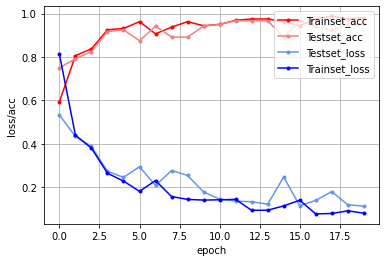

In [9]:
# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()
